In [1]:
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
import random
import matplotlib.pyplot as plt
from pycaret.classification import *

import sys
sys.path.append('../../../scripts/')
from PreparaDataset import *

# Parâmetros do método

In [2]:
TARGET = 'Back_HA_Zebra'
ODDS = 'Odds'

# Carregando o dataset

In [3]:
data = pd.read_csv('../../../data/Entire_Season.csv')

In [4]:
def prepara_dataset(_df):
    # HA
    _df.loc[(_df['Back_HA_H']) == 0, 'Back_HA_A'] = 1
    _df.loc[(_df['Back_HA_H']) == 1, 'Back_HA_A'] = 0
    _df.loc[(_df['Back_HA_H']) == 2, 'Back_HA_A'] = 2

    _df.loc[(_df['HA_Line']) > 0, 'Zebra'] = 'Casa'
    _df.loc[(_df['HA_Line']) < 0, 'Zebra'] = 'Fora'
    _df['Zebra'] = _df['Zebra'].astype('category')

    # Odds
    _df.loc[(_df['Zebra']) == 'Casa', 'Odds'] = _df['HA_Odds_H']
    _df.loc[(_df['Zebra']) == 'Fora', 'Odds'] = _df['HA_Odds_A']

    _df.loc[((_df['Zebra'] == 'Casa') & (_df['Back_HA_H'] == 1)), 'Back_HA_Zebra'] = 1
    _df.loc[((_df['Zebra'] == 'Casa') & (_df['Back_HA_H'] == 0)), 'Back_HA_Zebra'] = 0
    _df.loc[((_df['Zebra'] == 'Fora') & (_df['Back_HA_A'] == 1)), 'Back_HA_Zebra'] = 1
    _df.loc[((_df['Zebra'] == 'Fora') & (_df['Back_HA_A'] == 0)), 'Back_HA_Zebra'] = 0

    _df.reset_index(drop=True, inplace=True)

    # Limpa _df
    _df.replace([np.inf, -np.inf], 0, inplace=True)
    _df.dropna(subset=[TARGET], inplace=True)
    # _df = _df[(_df['Avg_CG_H'] != 0) & (_df['Avg_CG_A'] != 0) & (_df['DP_CG_H'] != 0) & (_df['DP_CG_A'] != 0) & (_df['MediaCustoGolAway'] != 0)]
    
    return _df

In [5]:
df = prepara_df(data)
df = prepara_dataset(df)

In [6]:
# TRAIN_SIZE = 0.625
# div = int(TRAIN_SIZE * len(df))

div = 3000
treino = df.iloc[:div, :]
val = df.iloc[div: , :]

print(f'Treino: {treino.shape[0]} | Validação: {val.shape[0]}')
print(f"Odd média: {treino[ODDS].mean():.2f}")
print(f"WR: {treino[TARGET].mean():.2f} (Odd justa: {1 / treino[TARGET].mean():.2f})")

Treino: 3000 | Validação: 2305
Odd média: 1.90
WR: 0.51 (Odd justa: 1.96)


# Validação 2

In [7]:
val1 = val[val['Date'] < '2023-10-20']
val2 = val[val['Date'] > '2023-10-19']

print(f'Validação 1: {val1.shape[0]} | Validação 2: {val2.shape[0]}')

Validação 1: 2146 | Validação 2: 159


# Criação do modelo

In [8]:
features = ['Odds_H', 'Odds_A', 'Over_Line', 'Odds_Over', 'Odds_Under', 'HA_Line',
       'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 'P(O)', 'P(U)', 'P_Diff', 'Porc_Over_Home',
       'Porc_Over_Away', 'Avg_CG_H', 'DP_CG_H',
       'CV_CG_H', 'Avg_CG_A', 'DP_CG_A', 'CV_CG_A', 'MediaCustoGolHome',
       'MediaCustoGolAway', 'Last_CG_H', 'Last_CG_A', 'Acima_Last_CG_H',
       'Acima_Last_CG_A', 'Abaixo_Last_CG_H', 'Abaixo_Last_CG_A', 'CV_ML',
       'CV_Over', 'CV_HA', 'Retornos_BH_Acu', 'Avg_Retornos_BH', 'Custo_Retorno_BH',
       'Avg_Porc_BH_Bookie', 'Avg_Porc_BH_Real', 'Dist_Porc_BH',
       'Retornos_BA_Acu', 'Avg_Retornos_BA', 'Custo_Retorno_BA',
       'Avg_Porc_BA_Bookie', 'Avg_Porc_BA_Real', 'Dist_Porc_BA', ODDS]

features = ['Odds_H', 'Odds_A', 'Odds_Over', 'Odds_Under', 'Over_Line',  'HA_Line', 'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 
       'P(O)', 'P(U)', 'P_Diff', 'CV_ML', 'CV_Over', 'CV_HA', ODDS]

features = ['Odds_H', 'Odds_Over', 'Odds_Under', 'Over_Line', 'HA_Line', 'P(A)', 'P(O)', 'P(U)', 'P_Diff', 'CV_ML', 'CV_Over', 'Odds']

In [9]:
def cria_setup(seed = 2023, features = features):
    cls = setup(data = treino,
            ignore_features = [x for x in treino.columns.to_list() if x not in features and x != TARGET],
            target = TARGET,
            train_size = 0.5,
            normalize = True,
            normalize_method = 'minmax',
            session_id = seed,
            remove_outliers = True,
            fix_imbalance = True,
            verbose = False
            )

In [ ]:
8941
4280

In [45]:
cria_setup(seed = 8941, features = features)

xtrain_treino = get_config('X_train')
ytrain_treino = get_config('y_train')
xtrain_teste = get_config('X_test')
ytrain_teste = get_config('y_test')

real_treino = pd.concat([xtrain_treino, ytrain_treino], axis=1)
real_teste = pd.concat([xtrain_teste, ytrain_teste],  axis=1)

In [ ]:
top = compare_models(exclude=['catboost', 'dummy'], fold = 5, sort='precision', n_select=14)

In [46]:
model = create_model('ada', cross_validation=False, return_train_score=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.5120,0.5175,0.5293,0.5225,0.5259,0.0232,0.0232
Train,0.5880,0.6367,0.5932,0.5979,0.5955,0.1757,0.1757


In [ ]:
tuned = tune_model(model, fold = 5, optimize = 'precision', return_train_score=True, n_iter=50)

In [189]:
ens_bagging = ensemble_model(model, fold = 5, method='Bagging', verbose=False)

In [13]:
def filtra_resultados(_df, filtro = 0):
    _df = _df[_df['prediction_label'] == 1]

    if filtro == 1:
        _df = _df[((_df['Odds'] > 1.85))]
        _df = _df[((_df['HA_Line'] <= -7)) & ((_df['HA_Line'] >= -13))]
    
    return _df

In [14]:
def calcula_profit(_df, stake = 1):
    _df.loc[(_df[TARGET] == 1), 'PL_BF_Predictions'] = (_df[ODDS] - 1) * stake
    _df.loc[(_df[TARGET] == 0), 'PL_BF_Predictions'] = - stake

    return _df

def exibe_metricas(_df, total, stake = 1, return_metrics = False):
    plb = _df['PL_BF_Predictions'].sum()
    entradas = _df.shape[0]
    wr = round((_df[_df[TARGET] == 1].shape[0] / entradas), 2)
    oddback = (_df[ODDS].mean())
    med_gain = _df[_df[TARGET] == 1]['PL_BF_Predictions'].mean()
    med_loss = _df[_df[TARGET] == 0]['PL_BF_Predictions'].mean()
    roi = plb / entradas
    porc_ent = entradas / total
    ev = (wr*stake*med_gain) + ((1-wr)*med_loss*stake)

    if return_metrics == False:
        print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | Prec.: {wr:.2f}')
        print(f'Odd média: {oddback:.2f} ({1/oddback:.2f} WR)')
        print(f'Média Gain: {med_gain:.2f} | Média Loss: {med_loss:.2f}')
        print(f'EM: {ev:.2f}')
        print(f'{entradas} entradas em {total} jogos ({100*porc_ent:.2f}%)')
    else:
        return_metrics == True
        metrics = [plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev]
        return metrics

def exibe_grafico(_df):
    _df.sort_index(inplace=True)
    _df.reset_index(drop=True, inplace=True)
    _df['hbacu'] = _df['PL_BF_Predictions'].cumsum()
    _df['hbacu'].plot.line(figsize=(7,2))
    plt.show()

def treina_modelo(modelo, data):
    _df = predict_model(modelo, data, verbose = False)
    _df = _df.merge(df[[TARGET]], left_index=True, right_index=True, how='left')
    if f'{TARGET}_x' in _df.columns.tolist():
        _df.rename(columns={f'{TARGET}_x': TARGET}, inplace=True)
        _df.drop(columns=f'{TARGET}_y', inplace=True)
    
    return _df

def info_modelo(modelo, data, stake = 1, filtro = 0):
    total = data.shape[0]

    _df = treina_modelo(modelo, data)
    _df = filtra_resultados(_df, filtro=filtro)
    _df = calcula_profit(_df, stake)
    exibe_metricas(_df, total, stake)
    exibe_grafico(_df)
    
    return _df


PL: 46.22 | ROI: 17.44% | Prec.: 0.62
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.18
265 entradas em 1500 jogos (17.67%)


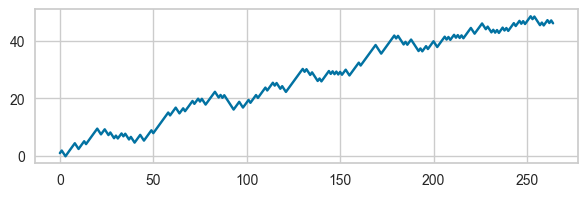

PL: 23.16 | ROI: 9.86% | Prec.: 0.58
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.10
235 entradas em 1500 jogos (15.67%)


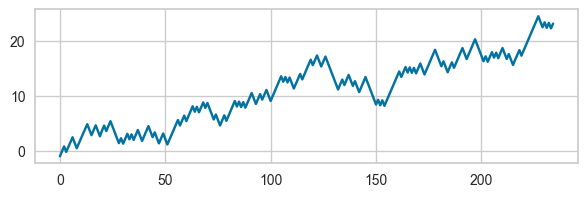

PL: 69.38 | ROI: 13.88% | Prec.: 0.60
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.14
500 entradas em 3000 jogos (16.67%)


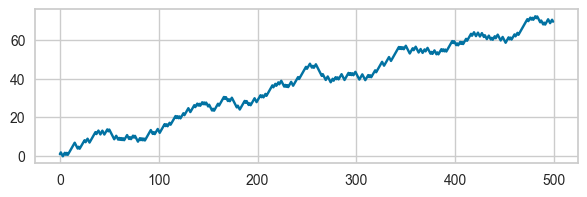

In [47]:
mdl = model
flt = 1
df_tr = info_modelo(mdl, real_treino, filtro = flt)
df_teste = info_modelo(mdl, real_teste, filtro = flt)
df_comp = info_modelo(mdl, treino, filtro = flt)

PL: 24.64 | ROI: 7.00% | Prec.: 0.56
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.07
352 entradas em 2305 jogos (15.27%)


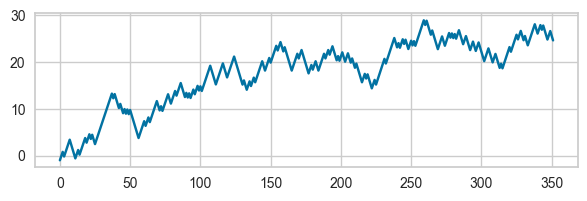

In [48]:
df_val = info_modelo(mdl, val, filtro = flt)

PL: 94.02 | ROI: 11.04% | Prec.: 0.58
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.10
852 entradas em 5305 jogos (16.06%)


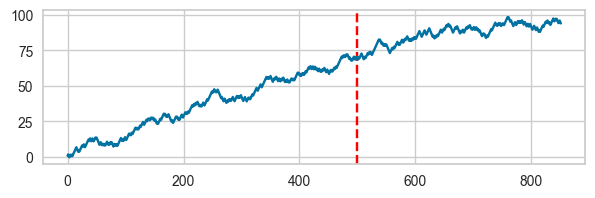

In [49]:
aux_comp = treina_modelo(mdl, treino)
aux_comp = filtra_resultados(aux_comp, filtro = flt)
plt.axvline(x=len(aux_comp), color='red', linestyle='--')
df_completo = info_modelo(mdl, pd.concat([treino, val1, val2]), filtro = flt)

# Comparação de modelos

### Escolhendo os modelos

DecisionTreeClassifier (i = 0)

PL: 32.33 | ROI: 6.85% | Prec.: 0.56
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.07
472 entradas em 3805 jogos (12.40%)


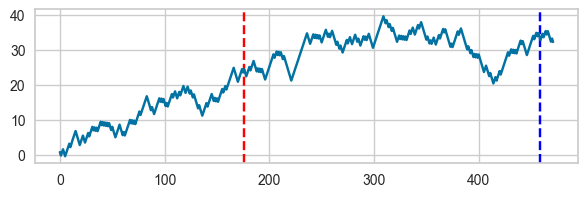

GradientBoostingClassifier (i = 1)

PL: 68.40 | ROI: 13.57% | Prec.: 0.60
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.14
504 entradas em 3805 jogos (13.25%)


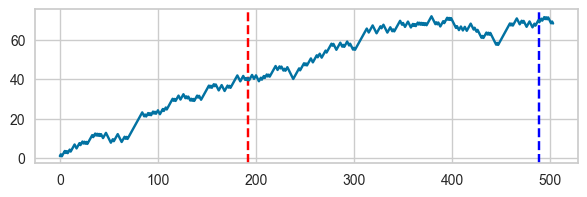

KNeighborsClassifier (i = 2)

PL: 38.36 | ROI: 7.16% | Prec.: 0.56
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.07
536 entradas em 3805 jogos (14.09%)


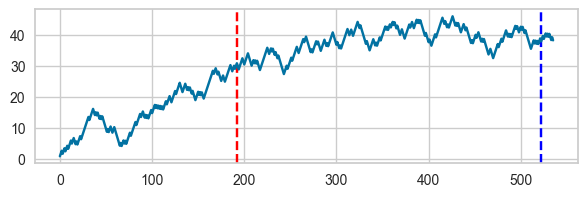

LGBMClassifier (i = 3)

PL: 29.01 | ROI: 5.23% | Prec.: 0.55
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.05
555 entradas em 3805 jogos (14.59%)


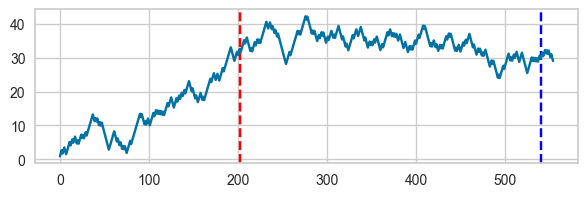

LinearDiscriminantAnalysis (i = 4)

PL: 48.03 | ROI: 11.41% | Prec.: 0.59
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.12
421 entradas em 3805 jogos (11.06%)


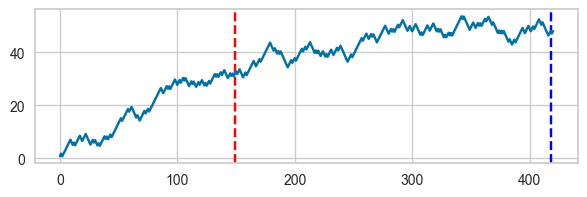

LogisticRegression (i = 5)

PL: 44.20 | ROI: 11.66% | Prec.: 0.59
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.12
379 entradas em 3805 jogos (9.96%)


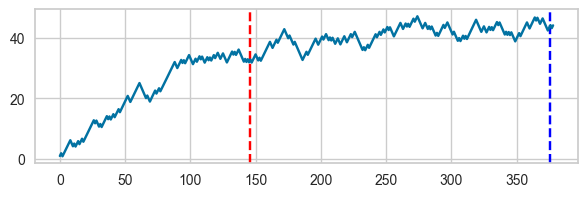

RandomForestClassifier (i = 6)

PL: 25.98 | ROI: 5.00% | Prec.: 0.55
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.05
520 entradas em 3805 jogos (13.67%)


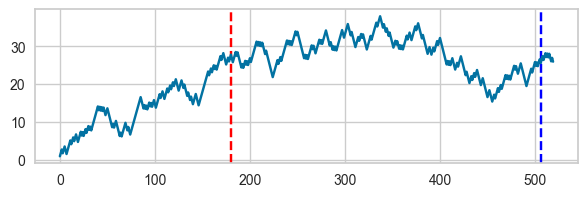

XGBClassifier (i = 7)

PL: 35.88 | ROI: 6.68% | Prec.: 0.56
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.07
537 entradas em 3805 jogos (14.11%)


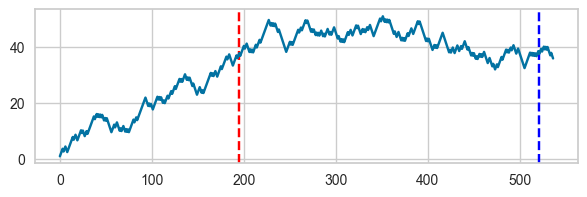

RidgeClassifier (i = 8)

PL: 45.04 | ROI: 11.18% | Prec.: 0.59
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.12
403 entradas em 3805 jogos (10.59%)


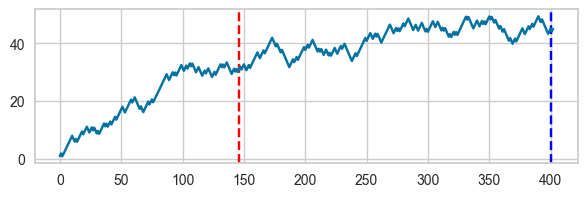

SGDClassifier (i = 9)

PL: 60.28 | ROI: 6.80% | Prec.: 0.56
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.07
886 entradas em 3805 jogos (23.29%)


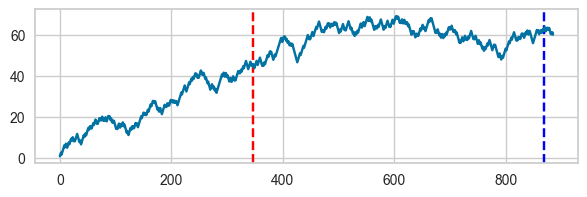

ExtraTreesClassifier (i = 10)

PL: 32.02 | ROI: 6.49% | Prec.: 0.56
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.07
493 entradas em 3805 jogos (12.96%)


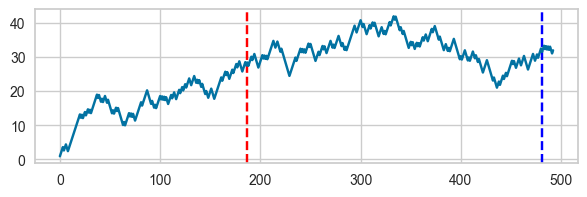

GaussianNB (i = 11)

PL: 57.92 | ROI: 8.92% | Prec.: 0.57
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.08
649 entradas em 3805 jogos (17.06%)


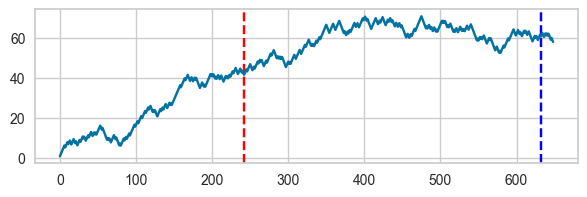

AdaBoostClassifier (i = 12)

PL: 68.31 | ROI: 11.09% | Prec.: 0.58
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.10
616 entradas em 3805 jogos (16.19%)


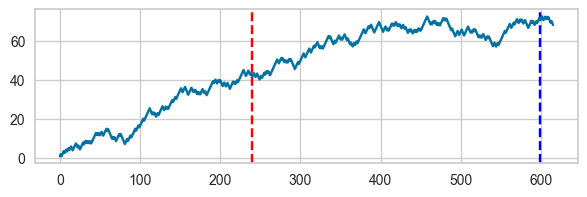

QuadraticDiscriminantAnalysis (i = 13)

O modelo apresentou um erro.



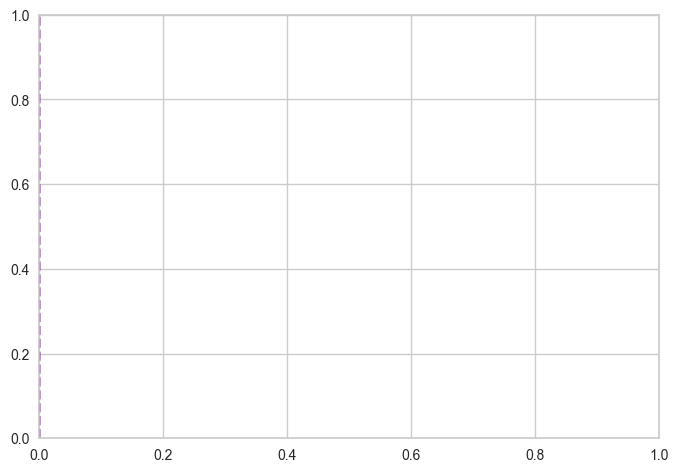

In [29]:
FILTRO = 1
CONJUNTO = 'val'

for i in range(14):
    try:
        if CONJUNTO != 'teste':
            print(f'{top[i].__class__.__name__} (i = {i})\n')
            aux_tr = treina_modelo(top[i], real_teste)
            aux_tr = filtra_resultados(aux_tr, filtro = FILTRO)
            plt.axvline(x=len(aux_tr), color='red', linestyle='--')
            aux_total = treina_modelo(top[i], val1)
            aux_total = filtra_resultados(aux_total, filtro = FILTRO)
            plt.axvline(x=len(aux_total) + len(aux_tr), color='blue', linestyle='--')
            aux = info_modelo(top[i], pd.concat([real_teste, val1, val2]), filtro = FILTRO)
        else:
            print(f'{top[i].__class__.__name__} (i = {i})\n')
            aux = info_modelo(top[i], real_teste, filtro = FILTRO)
    except:
        print(f'O modelo apresentou um erro.\n')
        pass

In [22]:
blended18 = blend_models(estimator_list = [top[1], top[8]], fold = 5, verbose=False)

In [23]:
model_list = [top[1], top[8], blended18]

### Resultados

GaussianNB

PL: 26.46 | ROI: 11.92% | Prec.: 0.54
Odd média: 2.11 (0.47 WR)
Média Gain: 1.07 | Média Loss: -1.00
EM: 0.12
222 entradas em 1637 jogos (13.56%)


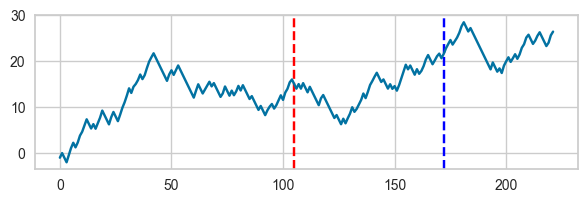

KNeighborsClassifier

PL: 19.83 | ROI: 11.53% | Prec.: 0.53
Odd média: 2.14 (0.47 WR)
Média Gain: 1.11 | Média Loss: -1.00
EM: 0.12
172 entradas em 1637 jogos (10.51%)


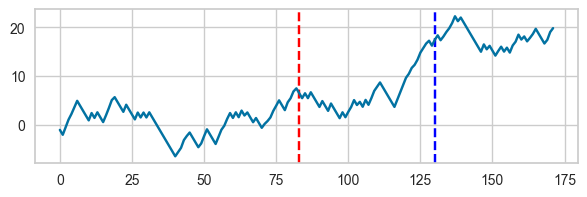

VotingClassifier

PL: 19.81 | ROI: 9.43% | Prec.: 0.53
Odd média: 2.10 (0.48 WR)
Média Gain: 1.05 | Média Loss: -1.00
EM: 0.09
210 entradas em 1637 jogos (12.83%)


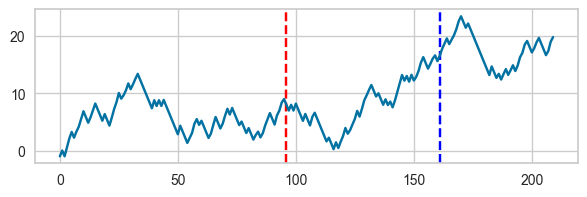

In [29]:
FILTRO = 2

for item in model_list:
    try:
        print(f'{item.__class__.__name__}\n')
        aux_tr = treina_modelo(item, real_teste)
        aux_tr = filtra_resultados(aux_tr, filtro = FILTRO)
        plt.axvline(x=len(aux_tr), color='red', linestyle='--')
        aux_total = treina_modelo(item, val1)
        aux_total = filtra_resultados(aux_total, filtro = FILTRO)
        plt.axvline(x=len(aux_total) + len(aux_tr), color='blue', linestyle='--')
        aux = info_modelo(item, pd.concat([real_teste, val]), filtro = FILTRO)
    except:
        print(f'O modelo apresentou um erro.\n')
        pass

# Script qcut

In [142]:
# df_cut1 = df_treino.copy()
df_cut = df_teste.copy()
# df_cut = pd.concat([df_cut1, df_cut2])

In [143]:
variaveis = features.copy()
variaveis.append('prediction_score')

for var in variaveis:
    try:
        nome = f'Cat_{var}'
        # Usa qcut para definir os grupos
        df_cut[nome]  = pd.qcut(df_cut[var], q = 10, duplicates='drop')

        target = 'PL_BF_Predictions'
        pivot_table = pd.pivot_table(df_cut,
                                    values=target,
                                    index=[nome],
                                    aggfunc=['sum', 'count']
                                    )
        

        pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

        aux_treino = pivot_table[pivot_table['ratio'] != 0]


        print(var)
        print(aux_treino)
        print()
        print('\n\n')
        print('------------------------------------------------')
        print('\n\n')
    except:
        pass

Odds_H
                                        sum             count     ratio
                          PL_BF_Predictions PL_BF_Predictions          
Cat_Odds_H                                                             
(1.0190000000000001, 1.1]             -7.40                36 -0.205556
(1.1, 1.14]                            3.70                21  0.176190
(1.14, 1.2]                           16.25                37  0.439189
(1.2, 1.25]                            6.91                33  0.209394
(1.25, 1.26]                          -2.55                14 -0.182143
(1.26, 1.28]                          -6.27                29 -0.216207
(1.28, 1.31]                           8.96                31  0.289032
(1.31, 1.33]                           4.26                28  0.152143
(1.33, 1.37]                           5.18                27  0.191852
(1.37, 2.15]                          11.16                23  0.485217




------------------------------------------------



O

In [ ]:
_df = _df[((_df['Avg_Retornos_BH'] >= -0.35) & (_df['Avg_Retornos_BH'] < 0.35)) | ((_df['Avg_Retornos_BH'] >= 3.7) & (_df['Avg_Retornos_BH'] < 5))]

_df = _df[((_df['Over_Line'] < 218) | (_df['Over_Line'] > 223))]


In [ ]:
# display(df_cut2.groupby('Cat_DP_Odds_Geral_H')['DP_Odds_Geral_H'].describe())

# Script variáveis

In [15]:
colunas = ['Odds_H', 'Odds_A', 'Over_Line', 'Odds_Over', 'Odds_Under', 'HA_Line',
       'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 'P(O)', 'P(U)', 'P_Diff', 'Porc_Over_Home',
       'Porc_Over_Away', 'Avg_CG_H', 'DP_CG_H',
       'CV_CG_H', 'Avg_CG_A', 'DP_CG_A', 'CV_CG_A', 'MediaCustoGolHome',
       'MediaCustoGolAway', 'Last_CG_H', 'Last_CG_A', 'Acima_Last_CG_H',
       'Acima_Last_CG_A', 'Abaixo_Last_CG_H', 'Abaixo_Last_CG_A', 'CV_ML',
       'CV_Over', 'CV_HA', 'Retornos_BH_Acu', 'Avg_Retornos_BH', 'Custo_Retorno_BH',
       'Avg_Porc_BH_Bookie', 'Avg_Porc_BH_Real', 'Dist_Porc_BH',
       'Retornos_BA_Acu', 'Avg_Retornos_BA', 'Custo_Retorno_BA',
       'Avg_Porc_BA_Bookie', 'Avg_Porc_BA_Real', 'Dist_Porc_BA']

colunas = ['Odds_H', 'Odds_A', 'Odds_Over', 'Odds_Under', 'Over_Line',  'HA_Line', 'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 
       'P(O)', 'P(U)', 'P_Diff', 'CV_ML',
       'CV_Over', 'CV_HA']

In [16]:
import random

def pegar_elementos_aleatorios(lista):
    # Gerar um número aleatório entre 2 e 7
    num_elementos = random.randint(5, 12)

    # Garantir que o número de elementos não ultrapasse o tamanho da lista
    num_elementos = min(num_elementos, len(lista))

    # Selecionar elementos aleatórios da lista
    elementos_aleatorios = random.sample(lista, num_elementos)

    return elementos_aleatorios

In [17]:
def cria_modelo(fts, _seed = 2023, _filtro = 0):
        try:
                cria_setup(features=fts, seed = _seed)

                model = create_model('ada', verbose = False, fold = 5)
                tab = pull()
                prec_model = (tab.loc['Mean', 'Prec.'])
                previsoes = predict_model(model, verbose = False)

                stake = 1

                total = previsoes.shape[0]

                previsoes = previsoes[previsoes['prediction_label'] == 1]
                previsoes = filtra_resultados(previsoes, filtro = _filtro)

                previsoes.loc[(previsoes[TARGET] == 1), 'PL_BF_Predictions'] = (previsoes[ODDS] - 1) * stake
                previsoes.loc[(previsoes[TARGET] == 0), 'PL_BF_Predictions'] = - stake

                plb = previsoes['PL_BF_Predictions'].sum()
                entradas = previsoes.shape[0]
                wr = round((previsoes[previsoes[TARGET] == 1].shape[0] / entradas), 2)
                oddback = previsoes[previsoes['prediction_label'] == 1][ODDS].mean()
                med_gain = previsoes[previsoes[TARGET] == 1]['PL_BF_Predictions'].mean()
                med_loss = previsoes[previsoes[TARGET] == 0]['PL_BF_Predictions'].mean()
                roi = plb / entradas
                porc_ent = entradas / total
                ev = (wr*stake*med_gain) + ((1-wr)*med_loss*stake)

                metrics = [prec_model, plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev]

                return metrics
        except Exception as e:
                print(e)
                return [0, 0, 0, 0, 0, 0, 0, 0, 0]

In [114]:
melhor_PL = -10000

for i in range(20):
    feats = pegar_elementos_aleatorios(colunas)
    feats.append(ODDS)

    metrics = cria_modelo(fts=feats)
    prec_model, plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev = metrics
            
    print(f'Rodada {i+1}')
    if plb > melhor_PL:
        melhor_PL = plb
        print(f'**Novo melhor**')
        print(f'Precision: {prec_model:.4f}')
        print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
        print(f'features = {feats}\n')
    print()

Rodada 1
**Novo melhor**
Precision: 0.4040
PL: -57.26 | ROI: -15.73% | EM: -0.16 | Prec.: 0.38 | Entradas: 0.49
features = ['Over_Line', 'CV_ML', 'Odds_Under', 'HA_Odds_A', 'P(U)', 'P_Diff', 'CV_Over', 'P(H)', 'Odds']


Rodada 2
**Novo melhor**
Precision: 0.4094
PL: -50.24 | ROI: -14.78% | EM: -0.16 | Prec.: 0.39 | Entradas: 0.46
features = ['HA_Line', 'Odds_H', 'P(H)', 'P_Diff', 'Odds_Over', 'CV_HA', 'P(U)', 'CV_Over', 'P(A)', 'CV_ML', 'Odds']


Rodada 3

Rodada 4
**Novo melhor**
Precision: 0.4263
PL: -48.52 | ROI: -13.86% | EM: -0.14 | Prec.: 0.39 | Entradas: 0.47
features = ['HA_Line', 'P(O)', 'CV_Over', 'P(H)', 'Over_Line', 'Odds']


Rodada 5

Rodada 6
**Novo melhor**
Precision: 0.4068
PL: -47.08 | ROI: -12.93% | EM: -0.14 | Prec.: 0.39 | Entradas: 0.49
features = ['Odds_Over', 'HA_Odds_H', 'Odds_A', 'P(H)', 'HA_Odds_A', 'Odds_Under', 'CV_Over', 'CV_ML', 'Over_Line', 'P_Diff', 'P(A)', 'P(O)', 'Odds']


Rodada 7

Rodada 8

Rodada 9
**Novo melhor**
Precision: 0.3952
PL: -46.74 | ROI:

# Segundo filtro

In [41]:
fits = ['Odds_H', 'Odds_A', 'Odds_Over', 'Odds_Under', 'Over_Line', 'HA_Line',  'P(H)', 'P(A)', 
       'P(O)', 'P(U)', 'P_Diff', 'CV_ML', 'CV_Over', 'CV_HA', ODDS]

fits = ['Odds_H', 'Odds_A', 'Odds_Over', 'Odds_Under', 'Over_Line', 'HA_Line', 'P(H)', 'P(A)', 'P(O)', 'P(U)', 'P_Diff', 'CV_ML', 'CV_Over', 'Odds']

fits = ['Odds_H', 'Odds_A', 'Odds_Over', 'Odds_Under', 'Over_Line', 'HA_Line', 'P(A)', 'P(O)', 'P(U)', 'P_Diff', 'CV_ML', 'CV_Over', 'Odds']

fits = ['Odds_H', 'Odds_Over', 'Odds_Under', 'Over_Line', 'HA_Line', 'P(A)', 'P(O)', 'P(U)', 'P_Diff', 'CV_ML', 'CV_Over', 'Odds']

In [42]:
metrics = cria_modelo(fits)
prec_model, plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev = metrics

print('---------------------- BASE ----------------------')
print(f'Precision: {prec_model:.4f}')
print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
print(f'fits = {fits}\n')
print('--------------------------------------------------')
melhor_PL = plb

for i in range(len(fits) - 1):
    feat = fits[i]
    fits.pop(i)
    print(f'Removido: {feat}')

    metrics = cria_modelo(fits)
    prec_model, plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev = metrics

    if plb >= melhor_PL:
        print('*** NOVO MELHOR ***')
        melhor_PL = plb
    print(f'Precision: {prec_model:.4f}')
    print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
    print(f'fits = {fits}\n')
    fits.insert(i, feat)
    print()

---------------------- BASE ----------------------
Precision: 0.5410
PL: 33.76 | ROI: 3.96% | EM: 0.04 | Prec.: 0.55 | Entradas: 0.57
fits = ['Odds_H', 'Odds_Over', 'Odds_Under', 'Over_Line', 'HA_Line', 'P(A)', 'P(O)', 'P(U)', 'P_Diff', 'CV_ML', 'CV_Over', 'Odds']

--------------------------------------------------
Removido: Odds_H
Precision: 0.5359
PL: 16.31 | ROI: 1.87% | EM: 0.02 | Prec.: 0.54 | Entradas: 0.58
fits = ['Odds_Over', 'Odds_Under', 'Over_Line', 'HA_Line', 'P(A)', 'P(O)', 'P(U)', 'P_Diff', 'CV_ML', 'CV_Over', 'Odds']


Removido: Odds_Over
Precision: 0.5337
PL: 31.23 | ROI: 3.58% | EM: 0.04 | Prec.: 0.55 | Entradas: 0.58
fits = ['Odds_H', 'Odds_Under', 'Over_Line', 'HA_Line', 'P(A)', 'P(O)', 'P(U)', 'P_Diff', 'CV_ML', 'CV_Over', 'Odds']


Removido: Odds_Under
Precision: 0.5357
PL: 30.56 | ROI: 3.70% | EM: 0.04 | Prec.: 0.55 | Entradas: 0.55
fits = ['Odds_H', 'Odds_Over', 'Over_Line', 'HA_Line', 'P(A)', 'P(O)', 'P(U)', 'P_Diff', 'CV_ML', 'CV_Over', 'Odds']


Removido: Over

# Cross validation

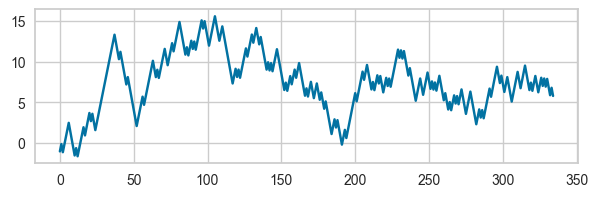

Fold 1 (seed 4984)
PL: 5.80 | ROI: 1.73% | EM: 0.01 | Prec.: 0.53 | Entradas: 0.15



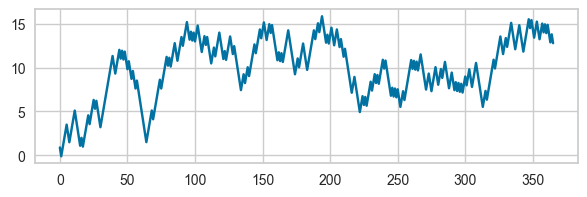

Fold 2 (seed 5325)
PL: 12.77 | ROI: 3.49% | EM: 0.03 | Prec.: 0.54 | Entradas: 0.16



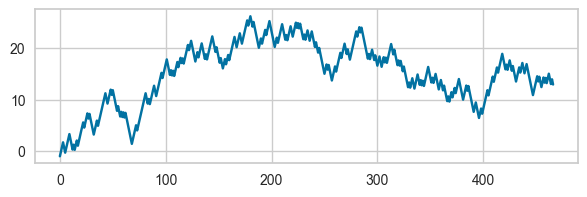

Fold 3 (seed 3943)
PL: 12.91 | ROI: 2.76% | EM: 0.03 | Prec.: 0.54 | Entradas: 0.20



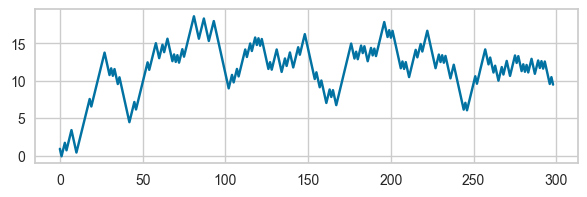

Fold 4 (seed 6444)
PL: 9.48 | ROI: 3.17% | EM: 0.03 | Prec.: 0.54 | Entradas: 0.13



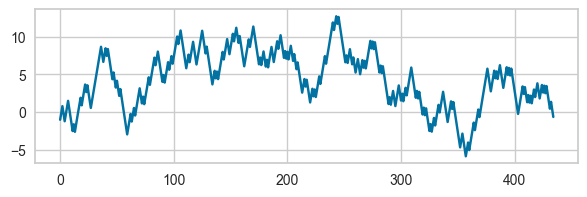

Fold 5 (seed 23)
PL: -0.63 | ROI: -0.14% | EM: -0.01 | Prec.: 0.52 | Entradas: 0.19



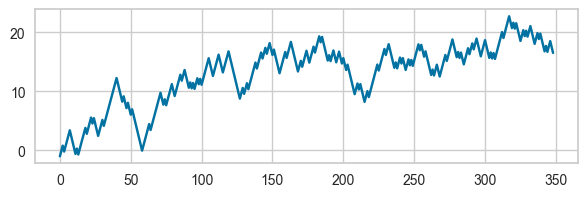

Fold 6 (seed 8100)
PL: 16.52 | ROI: 4.73% | EM: 0.05 | Prec.: 0.55 | Entradas: 0.15



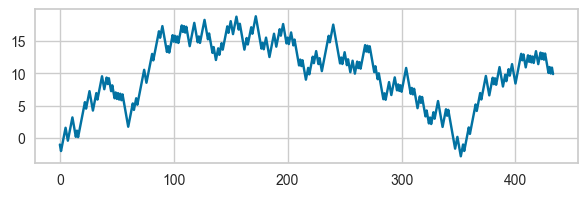

Fold 7 (seed 9084)
PL: 9.90 | ROI: 2.28% | EM: 0.03 | Prec.: 0.54 | Entradas: 0.19



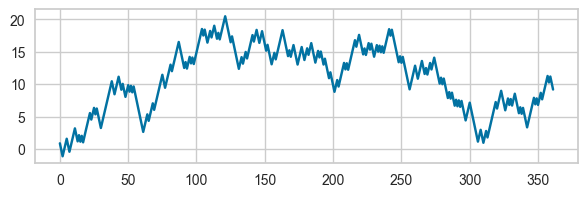

Fold 8 (seed 658)
PL: 9.19 | ROI: 2.54% | EM: 0.03 | Prec.: 0.54 | Entradas: 0.16



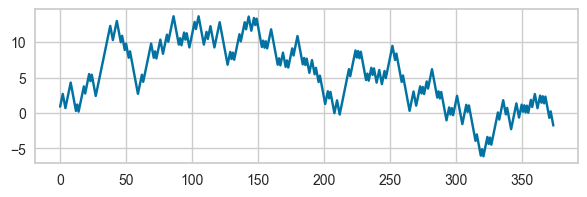

Fold 9 (seed 1180)
PL: -1.77 | ROI: -0.47% | EM: -0.01 | Prec.: 0.52 | Entradas: 0.16



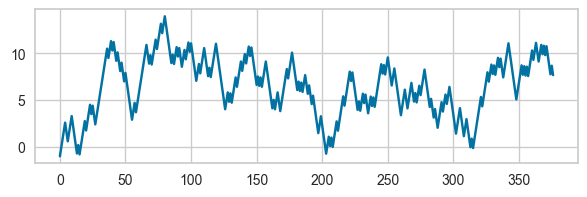

Fold 10 (seed 9341)
PL: 7.68 | ROI: 2.04% | EM: 0.03 | Prec.: 0.54 | Entradas: 0.16



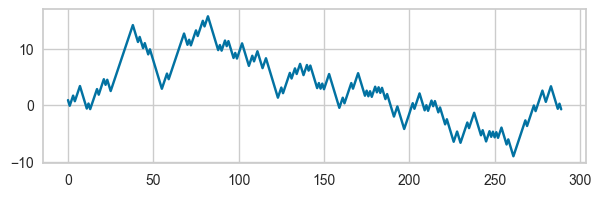

Fold 11 (seed 1608)
PL: -0.73 | ROI: -0.25% | EM: -0.01 | Prec.: 0.52 | Entradas: 0.13



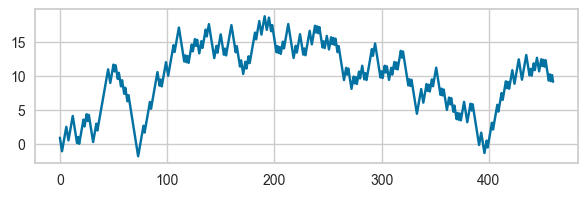

Fold 12 (seed 3968)
PL: 9.13 | ROI: 1.98% | EM: 0.03 | Prec.: 0.54 | Entradas: 0.20



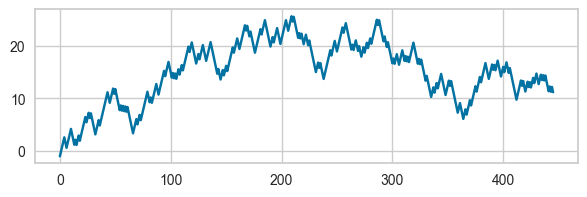

Fold 13 (seed 3586)
PL: 11.17 | ROI: 2.50% | EM: 0.03 | Prec.: 0.54 | Entradas: 0.19



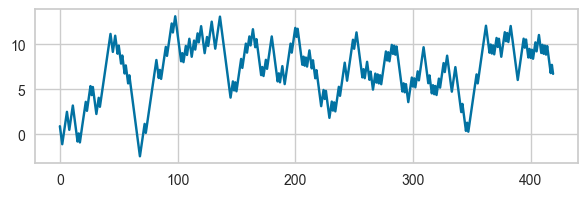

Fold 14 (seed 7308)
PL: 6.72 | ROI: 1.60% | EM: 0.01 | Prec.: 0.53 | Entradas: 0.18



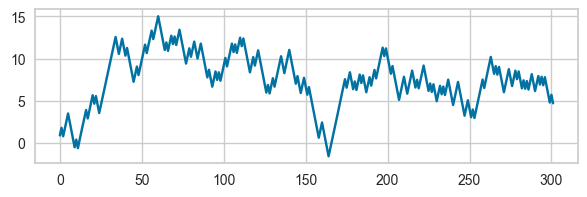

Fold 15 (seed 3071)
PL: 4.71 | ROI: 1.56% | EM: 0.01 | Prec.: 0.53 | Entradas: 0.13



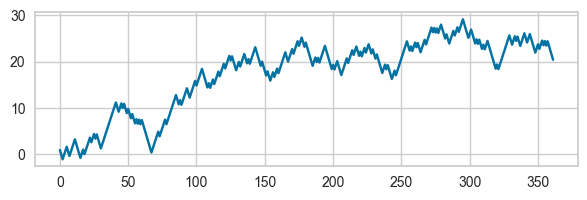

Fold 16 (seed 304)
PL: 20.38 | ROI: 5.63% | EM: 0.07 | Prec.: 0.56 | Entradas: 0.16



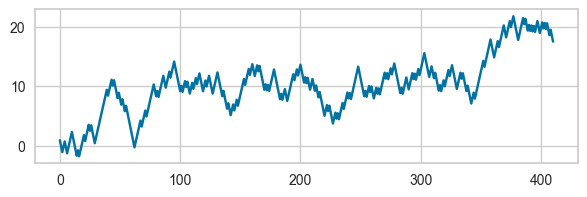

Fold 17 (seed 5715)
PL: 17.53 | ROI: 4.27% | EM: 0.05 | Prec.: 0.55 | Entradas: 0.18



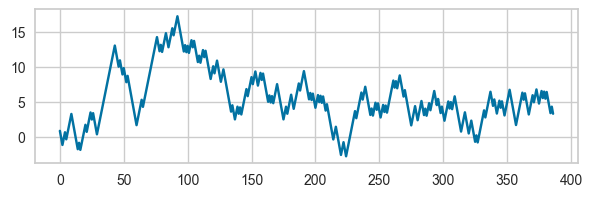

Fold 18 (seed 483)
PL: 3.33 | ROI: 0.86% | EM: 0.01 | Prec.: 0.53 | Entradas: 0.17



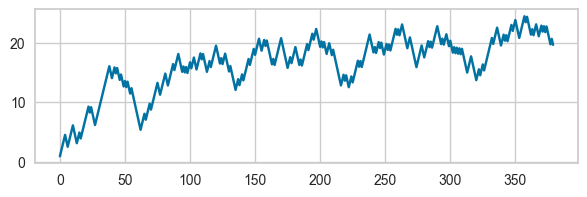

Fold 19 (seed 2238)
PL: 19.66 | ROI: 5.17% | EM: 0.05 | Prec.: 0.55 | Entradas: 0.16



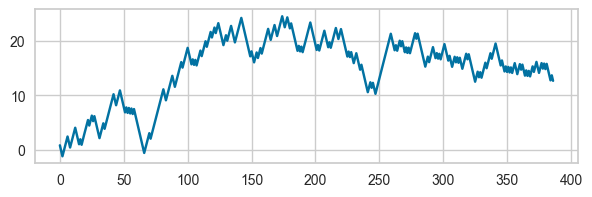

Fold 20 (seed 2386)
PL: 12.66 | ROI: 3.27% | EM: 0.03 | Prec.: 0.54 | Entradas: 0.17



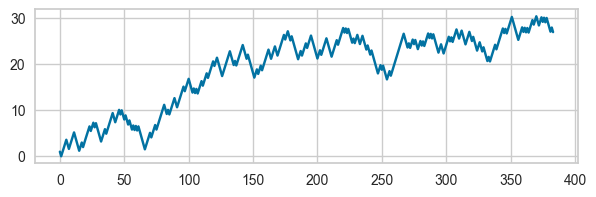

Fold 21 (seed 4280)
PL: 26.94 | ROI: 7.02% | EM: 0.07 | Prec.: 0.56 | Entradas: 0.17



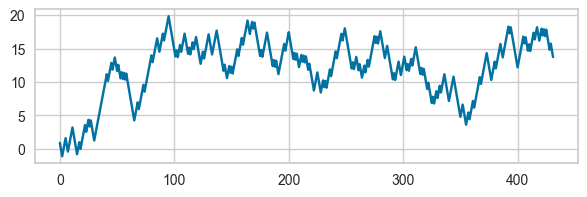

Fold 22 (seed 680)
PL: 13.73 | ROI: 3.18% | EM: 0.03 | Prec.: 0.54 | Entradas: 0.19



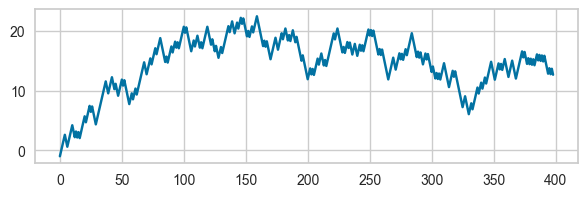

Fold 23 (seed 7877)
PL: 12.67 | ROI: 3.18% | EM: 0.03 | Prec.: 0.54 | Entradas: 0.17



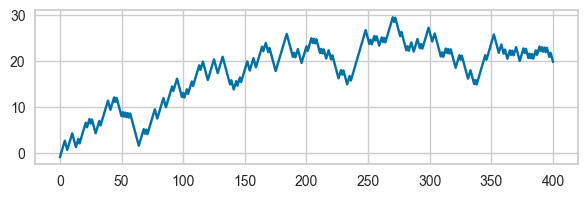

Fold 24 (seed 5699)
PL: 19.69 | ROI: 4.91% | EM: 0.05 | Prec.: 0.55 | Entradas: 0.17



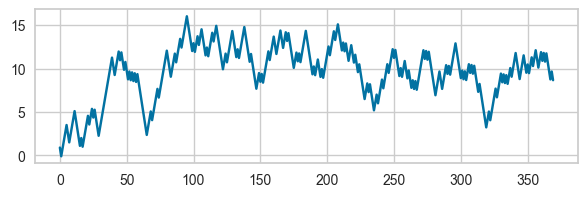

Fold 25 (seed 2348)
PL: 8.66 | ROI: 2.34% | EM: 0.03 | Prec.: 0.54 | Entradas: 0.16



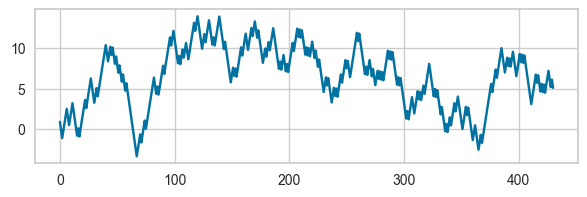

Fold 26 (seed 9486)
PL: 5.10 | ROI: 1.18% | EM: 0.01 | Prec.: 0.53 | Entradas: 0.19



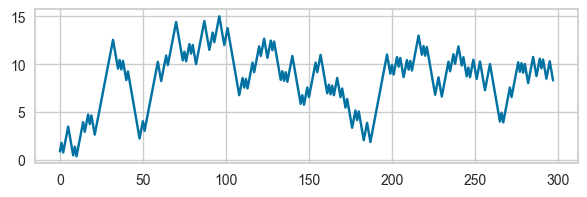

Fold 27 (seed 368)
PL: 8.32 | ROI: 2.79% | EM: 0.03 | Prec.: 0.54 | Entradas: 0.13



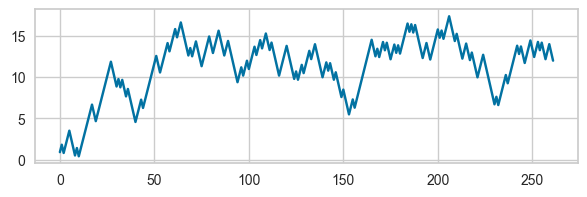

Fold 28 (seed 758)
PL: 11.99 | ROI: 4.58% | EM: 0.05 | Prec.: 0.55 | Entradas: 0.11



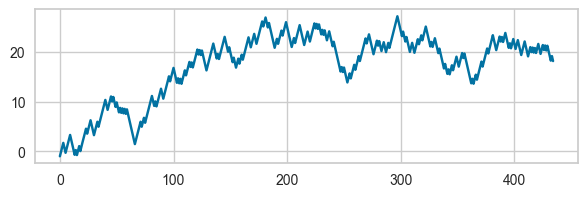

Fold 29 (seed 3073)
PL: 18.20 | ROI: 4.18% | EM: 0.05 | Prec.: 0.55 | Entradas: 0.19



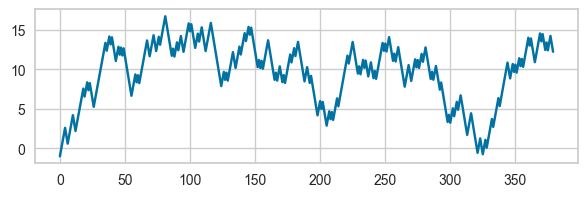

Fold 30 (seed 6010)
PL: 12.23 | ROI: 3.22% | EM: 0.03 | Prec.: 0.54 | Entradas: 0.16

Média: 0.54 | DP: 0.01


In [21]:
results = []
seeds = random.sample(range(0, 9999), 30)

for i in range(len(seeds)):

        cria_setup(seed=seeds[i], features=features)

        cross_model = create_model('ada', verbose = False, cross_validation=False)
        
        previsoes = predict_model(cross_model, val, verbose = False)
        previsoes = previsoes.merge(df[ODDS], left_index=True, right_index=True, how='left')
        if f'{ODDS}_x' in previsoes.columns.tolist():
                previsoes.rename(columns={f'{ODDS}_x': ODDS}, inplace=True)
                previsoes.drop(columns=f'{ODDS}_y', inplace=True)

        stake = 1

        total = previsoes.shape[0]

        previsoes = previsoes[(previsoes['prediction_label'] == 1)]

        previsoes.loc[(previsoes[TARGET] == 1), 'PL_BF_Predictions'] = (previsoes[ODDS] - 1) * stake
        previsoes.loc[(previsoes[TARGET] == 0), 'PL_BF_Predictions'] = - stake

        ############ Filtro ############
        previsoes = filtra_resultados(previsoes, filtro = 1)
        previsoes = calcula_profit(previsoes)
        exibe_grafico(previsoes)
        metrics = exibe_metricas(previsoes, total = total, return_metrics=True)
        plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev = metrics
        
        results.append(wr)

        print(f'Fold {i+1} (seed {seeds[i]})')
        print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
        print()

print(f'Média: {np.mean(results):.2f} | DP: {np.std(results):.2f}')

In [ ]:
6366
8941
8100
4280

# Entradas Aleatórias

In [ ]:
def new_random_model(_val, _n):

    for i in range(_n):
        random_df = _val.copy()
        random_df['Entrada'] = [random.choice([0, 1]) for _ in range(len(random_df))]

        random_df = random_df[random_df['Entrada'] == 1]
        random_df.loc[(random_df[TARGET] == 1), 'PL'] = (random_df[ODDS] - 1)
        random_df.loc[(random_df[TARGET] == 0), 'PL'] = - 1
        
        random_df.sort_values('Date', inplace=True)
        random_df.reset_index(drop=True, inplace=True)
        random_df['hbacu'] = random_df['PL'].cumsum()
        random_df['hbacu'].plot.line(figsize=(12,6))
    
    plt.show()

In [ ]:
new_random_model(val, 100)